# Hydrological Data Colection Center
***

**_Autor:_** Chus Casado Rodríguez<br>
**_Fecha:_** 04-09-2024<br>

**Introduction:**<br>
This code downloads the reservoir time series available in the HYDRO data base for a specific country.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from shapely.geometry import Point
import re
import requests
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from lisfloodreservoirs.utils import DatasetConfig, APIConfig

## Configuration

In [2]:
COUNTRY_ID = 'HR'

# dataset cofiguration
cfg = DatasetConfig(f'./ResOps{COUNTRY_ID}/config_dataset.yml')

# HDMS API configuration
api = APIConfig('./HDMS_API.yml')

# study period
strftime = '%Y-%m-%dT%H:%M:%S'

# variables of interest
VARIABLES = {
    'O': 'outflow',
    'V': 'volume',
    'R': 'level'
}

# directory of the HDMS dataset
PATH_HDMS = Path('Z:/nahaUsers/casadje/datasets/hDMS/reservoirs')

## Reservoirs

In [3]:
service = 'stationsmdv2'

url = f'{api.URL}/{service}/json/' #provider/{PROVIDER_ID}/'
response = requests.get(url, auth=requests.auth.HTTPBasicAuth(api.USERNAME, api.PASSWORD))
if response.status_code == 200:
    # convert to pandas
    reservoirs = pd.DataFrame(response.json())
    reservoirs.columns = reservoirs.columns.str.upper()
    reservoirs.set_index('EFAS_ID', drop=True, inplace=True)

    # keep only reservoirs in the specific country
    mask_type = reservoirs.TYPE == 'RESERVOIR'
    mask_country = reservoirs['COUNTRY-CODE'] == COUNTRY_ID
    reservoirs = reservoirs[mask_type & mask_country]

    # organize fields
    reservoirs.dropna(axis=1, how='all', inplace=True)
    reservoirs.drop(['LATITUDE_GEODESIC', 'LONGITUDE_GEODESIC', 'GEODESIC_REFERENCE_SYSTEM', 'VARIABLES', 'CATCHMENT_AREA_UNITS', 'HEIGHT_UNITS', 'TYPE'],
                    axis=1,
                    inplace=True,
                    errors='ignore')
    reservoirs.rename(columns={
         'HAS_RTDATA': 'DATA_RT',
         'HAS_HISTORICAL_DATA': 'DATA_HIST',
         'NAME': 'RES_NAME',
         'NATIONAL_STATION_IDENTIFIER': 'LOCAL_ID',
         'PROVIDER_ID': 'PROV_ID',
         'COUNTRY-CODE': 'COUNTRY_ID',
         'BASIN_ENGLISH': 'BASIN_EN',
         'BASIN_LOCAL': 'BASIN_LOC',
         'RIVERNAME_LOCAL': 'RIVER_LOC',
         'RIVERNAME_ENGLISH': 'RIVER_EN',
         'CATCHMENT_AREA': 'CATCH_SKM',
         'LATITUDE_WGS84': 'LAT',
         'LONGITUDE_WGS84': 'LON',
         'COORDINATES_CHECKED': 'COORD_TEST',
         'HEIGHT': 'DAM_HGT_M',
         'DATE_OF_STARTING_MEASUREMENT': 'START',
         'DATE_OF_ENDING_MEASUREMENT': 'END',
         'DATE_OF_REGISTRATION': 'REGISTERED',
         'LAST_CHANGE_COMMENT': 'COMMENT',
    }, inplace=True)
    reservoirs.sort_index(axis=1, inplace=True)

    # convert to geopandas
    geometry = [Point(xy) for xy in zip(reservoirs.LON, reservoirs.LAT)]
    reservoirs = gpd.GeoDataFrame(reservoirs, geometry=geometry)
    reservoirs.set_crs(epsg=4326, inplace=True)

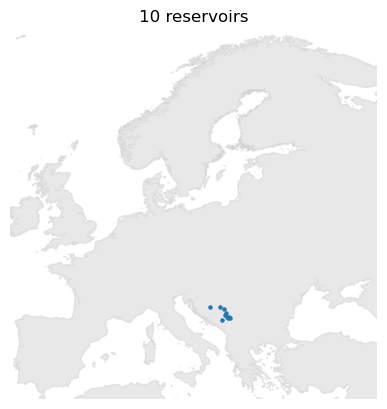

In [10]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
reservoirs.plot(markersize=5, ax=ax)
ax.set_title(f'{reservoirs.shape[0]} reservoirs')
ax.set_extent([-10, 40, 35.5, 70])
ax.axis('off');

In [12]:
# export
PATH_GIS = cfg.PATH_RESOPS / 'GIS'
PATH_GIS.mkdir(parents=True, exist_ok=True)
reservoirs.to_file(PATH_GIS / 'reservoirs_HDMS.shp')

In [ ]:
# # summarize data availability
# data_cols = reservoirs.columns[hdcc.columns.str.contains('[O|V|R]_Has_')].tolist()
# reservoirs[data_cols].astype(bool).sum()

## Timeseries

### Data range

```Python
service = 'hdatarange'
url = f'{api.URL}/{service}/'
response = requests.get(url + '9142', auth=requests.auth.HTTPBasicAuth(api.USERNAME, api.PASSWORD))

if response.status_code == 200:
    data = response.json()
    # Do something with the data
else:
    print("Failed to retrieve data from the API")
```

### Operational

In [13]:
service = 'nhoperational24hw'

# data must be downloaded in 4 batches due to server limitations
dates = [date.date() for date in pd.date_range(cfg.START, cfg.END, periods=4)]

# path where the data will be saved
path_out = PATH_HDMS / service
path_out.mkdir(parents=True, exist_ok=True)

pbar = tqdm(reservoirs.index, desc='reservoir', total=reservoirs.shape[0])
for ID in pbar:
    
    file_out = path_out / f'{ID}.nc'
    if file_out.exists():
        continue
    
    # download data
    data = {}
    for var, variable in VARIABLES.items(): # for each variable
        if 'serie' in locals():
            del serie
        serie = pd.DataFrame(columns=[ID], dtype=float)
        for i, (st, en) in enumerate(zip(dates[:-1], dates[1:])): # for each batch
            if i > 0:
                st += timedelta(days=1)           
            url = f'{api.URL}/{service}/{st.strftime(strftime)}/{en.strftime(strftime)}/{ID}/{var}/'
            response = requests.get(url, auth=requests.auth.HTTPBasicAuth(api.USERNAME, api.PASSWORD))
            if response.status_code == 200:
                serie_i = pd.DataFrame(response.json())
                if serie_i.shape[0] > 0:
                    serie_i = serie_i[['Timestamp', 'AvgValue']].set_index('Timestamp', drop=True)
                    serie_i.index = pd.to_datetime(serie_i.index)
                    serie_i.columns = [ID]
                    serie = pd.concat((serie, serie_i), axis=0)
        if serie.shape[0] > 0:
            data[variable] = serie.sort_index().copy()
        
    if len(data) > 0:
                        
        # convert to xarray.Dataset
        data = xr.Dataset({var: xr.DataArray(serie, dims=['date', 'ID']) for var, serie in data.items()})
        
        # export as NetCDF
        data.to_netcdf(file_out)
    else:
        print(f'No data was found for reservoir {ID}')

reservoir:   0%|          | 0/10 [00:00<?, ?it/s]

No data was found for reservoir 18144
No data was found for reservoir 18145
No data was found for reservoir 18146
No data was found for reservoir 18147
No data was found for reservoir 18148
No data was found for reservoir 18149
No data was found for reservoir 18150
No data was found for reservoir 18151
No data was found for reservoir 18152
No data was found for reservoir 18153
